# Performance Measures, Error Analysis, Classification
# 1. Binary classification

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

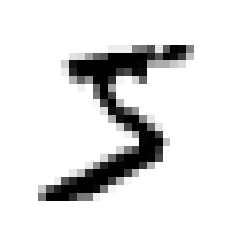

In [4]:
# each image is 28x28 pixels
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')
plt.show()

In [5]:
y[0] # the labels are string, we need to convert into integers

'5'

In [6]:
y = y.astype(np.uint8)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_test.shape)

(63000, 784) (7000, 784)


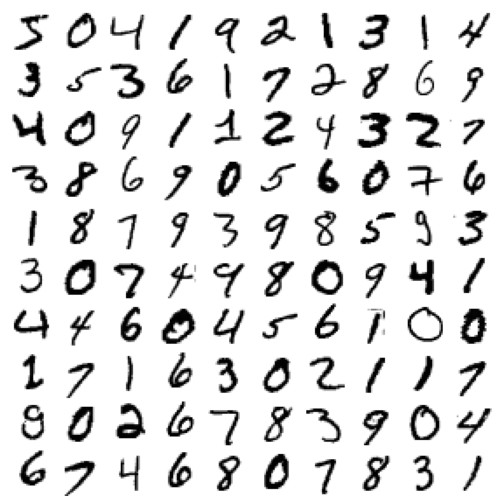

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # append empty image to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    
    # reshape the array to it's organized as a grid 28x28 images
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). First, move them to next each other by transpose() and then reshape
    big_image = image_grid.transpose(0,2,1,3).reshape(n_rows * size, images_per_row * size)
    # show the big image
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis('off')
    
    
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [9]:
from sklearn.linear_model import SGDClassifier

# Checking model classifying with a special case.
y_train_5 = (y_train == 5)   # collect all y is a num 5
y_test_5 = (y_test == 5)

# build a model classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# model predict on the num 5 only
sgd_clf.predict([some_digit])

## the model classifies this image is a 5 (True). Looks like model guessed right in this case.

array([ True])

# 2. Performance Measures
## 2.1. Measuring Accuracy using Cross-Validation
Custom Cross-Validation by StratifiedKFold class that performs stratified sampling, to produce folds that contain a representative ratio of each class. At each iteration the code create a clone of the classifier, train that clone on the training folds, and makes prediction on the testing fold. Then it counts the number of correct prediction and outputs the ratio of correct prediction.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # make a clone of the classifier
    # split train and test folds
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]    
    # using training for the test set
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9385238095238095
0.9553333333333334
0.9604761904761905


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

## accuracy is more than 96% (ratio of correct predictions), but look at classifier try to predict not-5 image.

array([0.96366667, 0.96142857, 0.96280952])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
not_5_clf = Never5Classifier()
cross_val_score(not_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

## over 90%, because only about 10% of images are 5s, if we guess image not-5, we will be right about 90% of time 

array([0.90709524, 0.9117619 , 0.91061905])

## 2.2 Confusion Matrix
The idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, firstly need to have a set of predictions, so they can be compared to the actual targets.

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_predict)

array([[56302,  1017],
       [ 1337,  4344]])

$array([[56590,   701], [ 1333,  4376]])$
- Each row represents actual class, column represents a predicted class. 
- First row considers non-5 images (the negative class): 56590 is correctly classified as non-5s (TN).
- While 701 were wrongly classified as 5s (FP).
- The second row contains the images of 5s (the positive class): 1333 were wrongly classified as non-5s (FN)
- While 4376 were correctly classified as 5s (TP).

A perfect classifier would have only true positives (TP) and true negatives (TN), so its confusion matrix would have nonzero values only on its main diagonal (Top left to bottom right).

1. The accuracy of the positive predictions: Precision

$\displaystyle{precision = \frac{TP}{TP + FP}}$

2. The ratio of positive instances that are correctly detected by the classifier, called True Positive Rate (TPR) or Recall.

$\displaystyle{recall = \frac{TP}{TP + FN}}$

3. F1_score: the combination of precision and recall, called Harmonic Mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values

$\displaystyle{F_1 = 2 x \frac{precision x recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}}$

<img src="images/confusion_matrix.png" style="width:400px; high:320px"/>

## 2.3. Precision, Recall and F1_score
Sometime, the Precision is more important than Recall, for example, when detect videos safe for kids, we must reject good videos (low recall) but keep safe ones (high precision). rather than a classifier that has a much higher recall but lets a few bad videos.

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train_5, y_train_predict)
recall = recall_score(y_train_5, y_train_predict)
f1 = f1_score(y_train_5, y_train_predict)
print("precision: ", precision)
print('recall: ', recall)
print('f1 score: ', f1)

## Accuracy of correct classify as 5s: 86.19% of the time. and only detects 76.65% of 5s.
## Harmonic mean of precision/recall is also high: 81.14%

precision:  0.8102965864577504
recall:  0.7646541101918676
f1 score:  0.7868139829740989


## 2.4. Precision/Recall Tradeoff
Normally, we cannot have both high precision and recall, Increase Precision reduces Recall and vice versa.

For each instance, Classifier (i.e., SGDClassifier) computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns instance to the negative class.

Lowering the Decision threshold increases the Recall and reduce Precision.

Sklearn does not alow to set the threshold directly, but it does give we access to the decision score that it use to make prediction. Instead of calling the classifier's predict() method, we can call its decision_function() method, which return the score for each instance, and then make predictions based on those score using any threshold you want.

In [15]:
# using decision_function() instead of predict() of the classifier.
y_scores = sgd_clf.decision_function([some_digit])  # get score of image 5.
y_scores

array([470.61101878])

In [16]:
# if threshold = 0
threshold = 0
y_5_predict = (y_scores > threshold)
y_5_predict

## Lower threshold increase the Recall, the returned result is the same as predict() method (e.g., True).

array([ True])

In [17]:
# raise the threshold
threshold = 1000
y_5_predict = (y_scores > threshold)
y_5_predict

## raising the threshold decreases Recall. The image actually represents a 5s, but missing with high threshold.
## So, how we decide which threshold to use? 
## First, need to get the score of all instances in the training set cross_val_predict(), but returning is the 
## decision scores instead of prediction
## These scores is computed the precision and recall for all possible threshold by using precision_recall_curve() 
## Finally, plot a precision and recall to pick the right precision for the project.

array([False])

In [18]:
from sklearn.metrics import precision_recall_curve

# return the score for each instance after prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

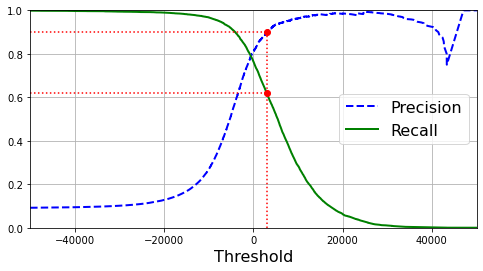

In [19]:
# ploting 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

    
# get score of decided threshold when precision = 90%
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# plot everything and the point of 90%
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # line cuts the 90 precision 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')  # line to the precision point
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:') # line to the recall
plt.plot([threshold_90_precision], [0.9], 'ro')  # the point on precision curve
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')  # point on the recall curve
plt.show()

In [20]:
# all the preditions have scores > 0
(y_train_predict == (y_scores > 0)).all()

True

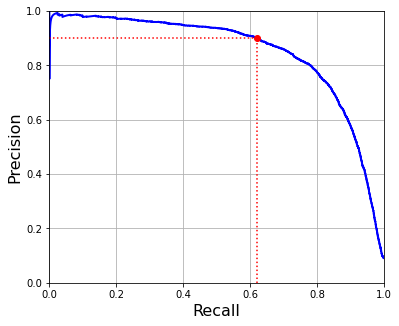

In [21]:
## Precision vs. Recall
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize="16")
    plt.ylabel('Precision', fontsize="16")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    

plt.figure(figsize=(6, 5))
plot_precision_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()

## The Precision is fallen sharply around 80% Recall. We will probably select a precision/recall tradeoff before
## that drop. So, suppose we decide to take 90% precision

In [22]:
# get the threshold at 90% of Precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3025.5131594312797

In [23]:
# How much the precision and recall of this threshold.
y_train_pred_90 = (y_scores >= threshold_90_precision)

# let's check these prediction's precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9002047082906858

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.6192571730329167

- Done, We have a 90% precision classifier.
- We can create any model with desired precision we want. But a high-precision is not very useful if its recall is too low.

## 2.5. The ROC Curve
The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers. The ROC plot True Positive Rate (recall) against the False Positive Rate. 

The FPR is the ratio of negative instances that are incorrectly classified as positive.

$ FPR = 1 - TNR$, the TNR is the ratio of negative instances that are correctly classified as negative. 

The TNR is called specificity, the ROC curve plot sensitivity (recall) versus 1 - specificity

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

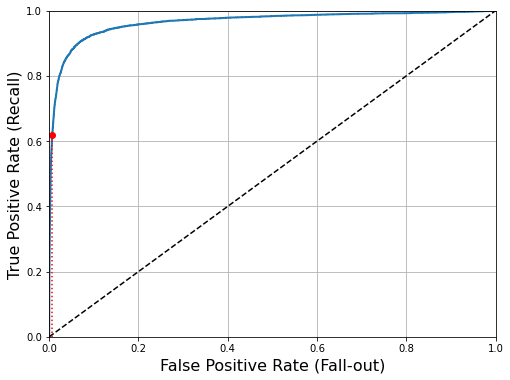

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dash diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores)

0.9654344062143634

- The higher the Recall (TPR), the more false positives (FPR) the classifier produces.
- The diagonal represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

To compare classifiers that is a measurement of the area under curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In practice, using Precision/Recall (whenever the positive class is rare or care about the false positive than the false negative). The PR curve makes clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

In [29]:
# Compares 2 classifiers SGD and RandomForest
from sklearn.ensemble import RandomForestClassifier

## RandomForest doesn't have decision_function() to return a score for each instance. 
## using predict_proba() method returns an array which containing a row per instance and a column per class.
## So, each probability is the given instance belongs to the given class.
# random_state param for reproducible results
forest_clf = RandomForestClassifier(random_state=42, n_estimators=100) 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [30]:
## The ROC curve needs the scores, not the probabilities. Simple solution, we can use
## the positive class's probability as the score.
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

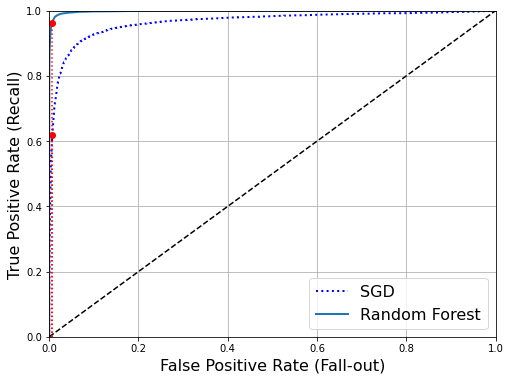

In [31]:
# plot the curve of forest
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], 'r:')
plt.plot([fpr_90], [recall_for_forest], 'ro')
plt.grid(True)
plt.legend(loc='lower right', fontsize='16')
plt.show()

In [32]:
y_probas_forest[0]

array([0.99, 0.01])

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984662986606065

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
preci_forest = precision_score(y_train_5, y_train_pred_forest)
recall_forest = recall_score(y_train_5, y_train_pred_forest)
print('forest precision= ', preci_forest)
print('forest recall= ', recall_forest)

forest precision=  0.9909602249899558
forest recall=  0.8683330399577539


- the ROC curve of RandomForest comes much closer to the top-right corner, its classifier is much better than SGD's classifier.
- We find the 99% precision and 86.83% of recall, not too bad.

The single-detector (classify only image num 5s) with binary classifier, choose the appropriate metric for the task, evaluate the classifier using cross-validation, select the precision/recall tradeoff that fit our needs, and compare various models using ROC curve, and ROC AUC scores.

# 3. Multiclass Classification
The binary classifiers distinguish between two classes, multiclass classifiers (multinomial classifiers) can distinguish more than two classes.

Some algorithms (RandomForest or NaiveBayes classifier) can handle multiclass directly. Others (SVM or Linear) are strictly binary classifiers. However, there are various strategies that we can use to perform multiclass classification using multiple binary classifiers.

For example, classify digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, 1-detector,...). Then when we want to classify an image, we get the decision score from each classifier for that image and we select the class whose classifier outputs the highest score. That is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, 0s and 2s, 1s and 2s, and so on. This is called One-versus-One (OvO) strategy. If there have N classes, we need N(N - 1)/2 classifiers. When we classify an digit image, we need to run over all classifiers and select the output which has the highest score. An advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (SVM) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, OvA is preferred. 


In [36]:
## SGD classifier trained 10 binary classifiers, got their decision scores for the image
## and selected the class with the highest score.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
## return 10 scores, one per class from each classifiers.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-16492.35506617, -33208.71360238,  -4739.20628659,
           435.27954743, -23631.23580001,    630.72425613,
        -24812.06579287,  -9660.57398521,  -2331.91097473,
        -11909.65287794]])

In [38]:
## the highest score, corresponding by the class.
np.argmax(some_digit_scores)  # return the index of array

5

In [39]:
## when a classifier is trained, it stores the list of target classes in its classes_ attribute.
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
# We can use one-versus-one or one-versus-all with OneVsOneClassifier or OneVsRestClassifier classes.
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
## let's try with randomforest classifier
## RandomForest can directly classify instances into multiple classes (without runing OvO or OvA)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
forest_clf.predict_proba([some_digit])

## the model predicts 88% probability that image represents a 5, 
## and it also thinks of 2, 3 or 7 which probability are 2%, 9%, and 1%

array([[0.  , 0.  , 0.02, 0.09, 0.  , 0.88, 0.  , 0.01, 0.  , 0.  ]])

In [44]:
## Evaluate Classifiers with cross-val-score
#cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

## it gets over 87% of all test folds. if we want to improve the test score, we can simply scaling the inputs

array([0.87928571, 0.87542857, 0.87833333])

In [45]:
# Scale the input to improve the accuracy.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

# 4. Error Analysis
Steps in ML project: Exploring the data preparation options, Trying out multiple models, Shortlisting the best ones, Fine-Tuning their hyperparameters using GridSearchCV, and Automating as much as possible.

Here, we want to improve the model by analyze the types of errors it makes.

In [46]:
## First, look at the confusion matrix, by using the cross_val_predict()
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/chuongnet/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5855,    0,   17,    8,    9,   39,   38,    4,  221,    1],
       [   1, 6784,   39,   17,    4,   46,    8,    8,  189,   11],
       [  29,   27, 5579,   92,   80,   25,   64,   45,  365,   10],
       [  23,   19,  124, 5499,    1,  224,   26,   43,  395,   68],
       [  10,   12,   53,    7, 5484,    6,   39,   22,  342,  177],
       [  31,   16,   30,  166,   59, 4729,   88,   17,  482,   63],
       [  30,   16,   52,    2,   48,   95, 5822,    6,  139,    0],
       [  26,   12,   68,   21,   46,   12,    6, 6007,  183,  203],
       [  18,   58,   49,   87,    3,  134,   34,   12, 5676,   43],
       [  19,   22,   30,   58,  139,   41,    1,  182,  342, 5388]])

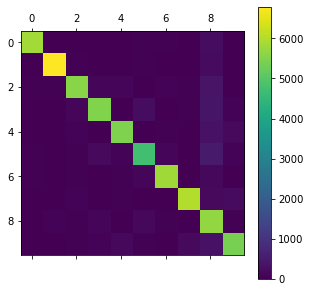

In [49]:
# from sklearn.metrics import plot_confusion_matrix
def plot_conf_mx(matrix):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_conf_mx(conf_mx)
plt.show()

## most image are on the main diagonal, which means that they were classified correctly.
## The 5s look lower number, that means some image of 5s in the dataset that the classifier doesn't perform well.

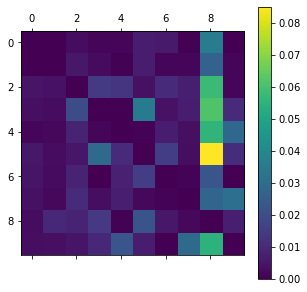

In [51]:
## Analysis the ERROR: First, devide each value in the confusion matrix 
## by the number of images in the corresponding class, so we can compare error rate instead of 
## absolute number of errors.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

# Now, fill the diagonal with 0 to keep only the errors.
np.fill_diagonal(norm_conf_mx, 0)
# plot
plot_conf_mx(norm_conf_mx)

## The column of class 8 is quite not good, that predicted images are misclassified as 8s
## The row of class 8 is quite well, that actual 8s is classified as 8s
## We can see the 3s and 5s often get confused (in both directions)

Confusion matrix gives insights on the way to improve the classifier. Look at this plot, we need to reduce the false 8s such as:
- gather more training data for digits that look like 8s (but not) so the classifier can learn to distinguish them from the real 8s.
- or engineering new features that would help the classifier, for example, writing an algorithm to count the number of closed loops (e.g., 8 has 2, 6 has 1, 5 has none).
- or preprocess the images (e.g., using Sklearn-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

# 5. Multilabel Classification
The classifier produces to output multiple classes for each instance. 

The classification system that outputs multiple binary tags is called a multiclass classification system.

KNeighborsClassifier supports multilabel classification. 

In [52]:
from sklearn.neighbors import KNeighborsClassifier

# create multilabel y
y_train_large = (y_train >= 7)  # get all number >= 7
y_train_odd = (y_train%2 == 1)  # get the odd numbers

y_multilabel = np.c_[y_train_large, y_train_odd]

display(len(y_multilabel), y_multilabel[0])

63000

array([False, False])

In [53]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

## indee, the digit 5 is not large (False), and odd (True)
## There many ways to Evaluate a multilable classifier

array([[False,  True]])

In [54]:
## Evaluate classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9773366990559669

# 6. Multioutput Classification
Multioutput-multiclass classification.

Generalization of Multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities.

In [58]:
# create noisy input
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train  # cleared image output
y_test_mod = X_test

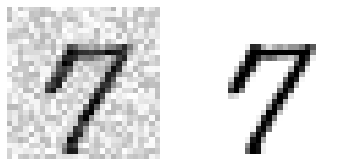

In [59]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

    
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

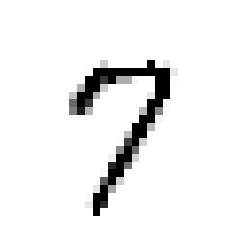

In [60]:
# classify 
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## KNN Classifier

In [61]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [62]:
y_knn_pred = knn_clf.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9727142857142858

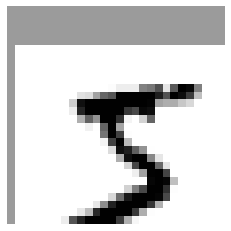

In [64]:
## shift image
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dx, dy], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [65]:
ambi_digit = X_test[2589]
knn_clf.predict_proba([ambi_digit])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

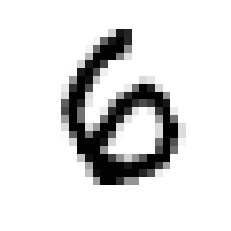

In [66]:
plot_digit(ambi_digit)